## Compare Random Forest in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_random_forest,
)

In [2]:
metric = "accuracy"

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline CatBoost Classifier without new data + r

In [85]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [86]:
# orig_df["r"] = interest_rate

### In sample predictions

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=False
)

In [88]:
X_train.describe()

,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_VOLUME,diff_date
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1152.000000,1253.000000
mean,344.610088,344.594972,5.785036,5.712195,5.780383,0.176465,337.571181,20.660016
std,66.858522,66.861470,2.771393,2.609097,2.644117,0.082716,962.843679,0.594951
min,222.210000,222.000000,0.000000,1.450000,1.490000,0.068710,0.000000,18.000000
25%,284.030000,284.500000,3.580000,3.580000,3.640000,0.117850,51.000000,20.000000
50%,326.880000,327.000000,5.250000,5.210000,5.270000,0.160440,144.000000,21.000000
75%,406.060000,405.000000,7.510000,7.440000,7.510000,0.212460,314.000000,21.000000
max,477.770000,478.000000,26.160000,17.760000,18.230000,0.775330,21230.000000,23.000000


In [89]:
X_test.describe()

,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_VOLUME,diff_date
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,427.449196,427.464824,6.475226,6.434372,6.462663,0.146217,1374.100503,21.110553
std,22.910239,22.904198,1.263643,1.198533,1.199812,0.034104,1422.668328,1.816824
min,379.380000,379.000000,3.990000,4.140000,4.180000,0.092440,2.000000,18.000000
25%,410.315000,410.500000,5.465000,5.455000,5.470000,0.116345,460.000000,21.000000
50%,429.130000,429.000000,6.500000,6.460000,6.480000,0.141030,957.000000,22.000000
75%,445.860000,446.000000,7.420000,7.320000,7.345000,0.173220,1745.000000,23.000000
max,476.730000,477.000000,11.250000,9.540000,9.600000,0.249030,8690.000000,23.000000


In [97]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier()),
    ]
)

In [98]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf', RandomForestClassifier())])

In [99]:
pipe.score(X_train, y_train)

1.0

In [100]:
predictions = pipe.predict(X_test)

In [101]:
pipe.score(X_test, y_test)

0.542713567839196

              precision    recall  f1-score   support

           0       0.53      0.72      0.61        98
           1       0.58      0.37      0.45       101

    accuracy                           0.54       199
   macro avg       0.55      0.55      0.53       199
weighted avg       0.55      0.54      0.53       199



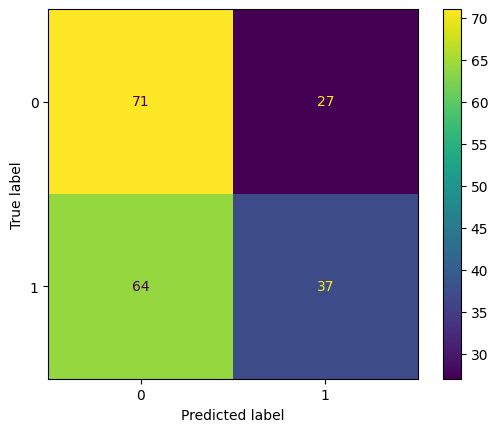

In [102]:
display_report(y_test, predictions)

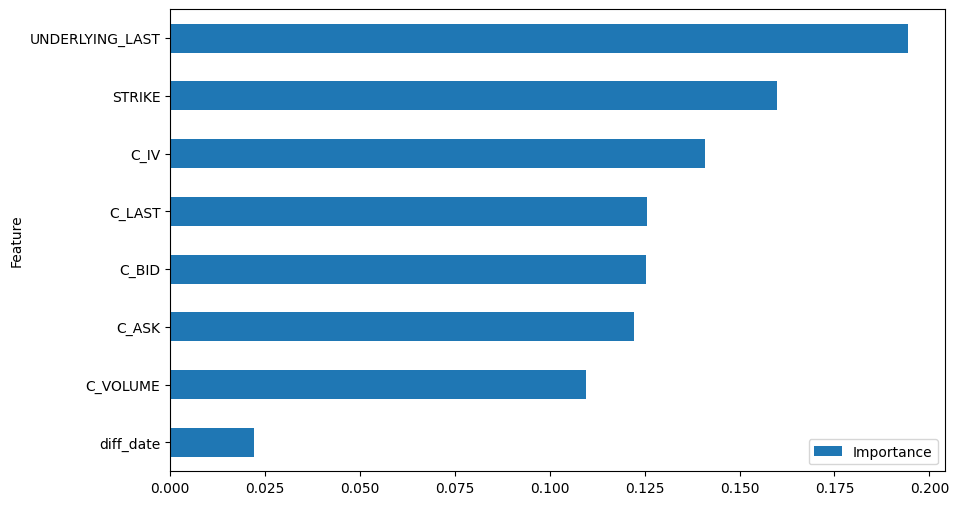

In [103]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [104]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [105]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [106]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,227.540013,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,227.540013,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,227.540013,401.389886


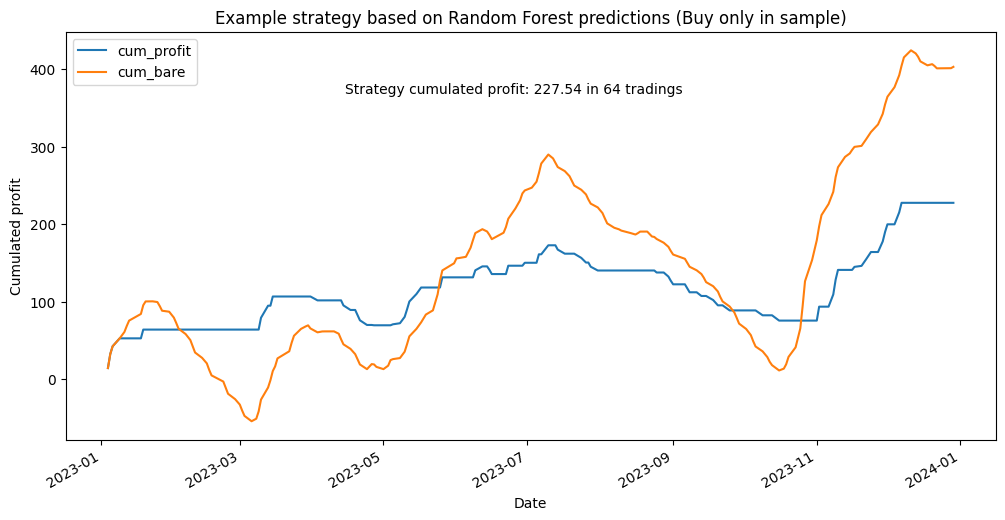

In [107]:
plot_strategy(strategy_df, "Random Forest", "(Buy only in sample)")

## Random Forest with data from MC simulation and additional features

In [108]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [109]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In-sample predictions

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=False
)

In [111]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier()),
    ]
)

In [112]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf', RandomForestClassifier())])

In [114]:
pipe.score(X_train, y_train)

1.0

In [115]:
predictions = pipe.predict(X_test)

In [116]:
pipe.score(X_test, y_test)

0.5778894472361809

              precision    recall  f1-score   support

           0       0.56      0.65      0.60        98
           1       0.60      0.50      0.55       101

    accuracy                           0.58       199
   macro avg       0.58      0.58      0.58       199
weighted avg       0.58      0.58      0.58       199



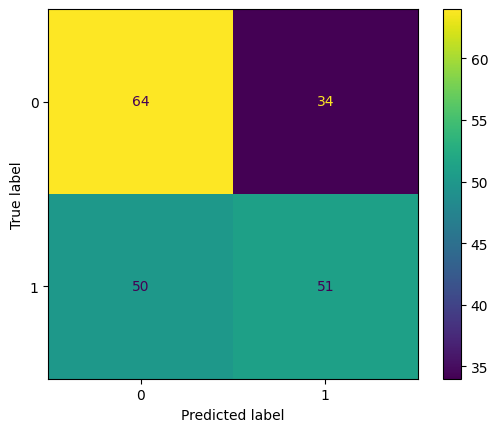

In [117]:
display_report(y_test, predictions)

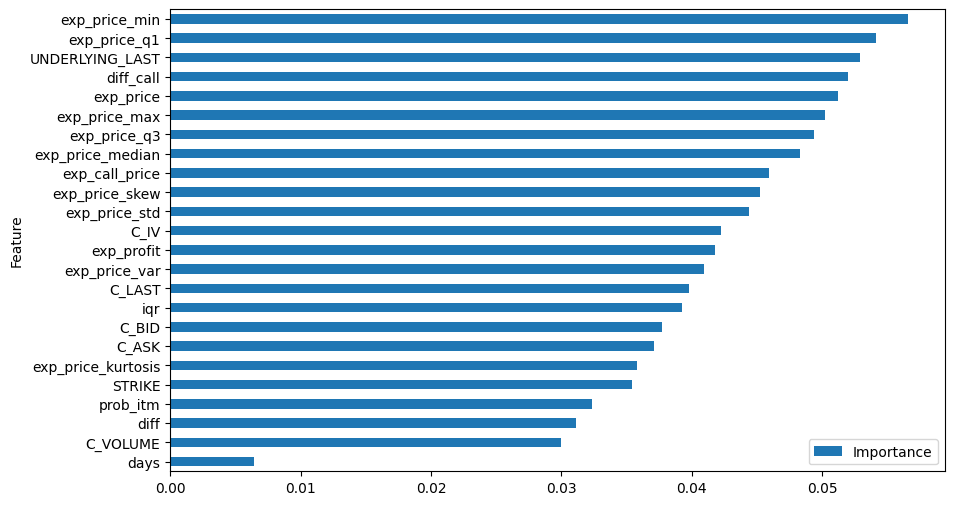

In [118]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [119]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [120]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [121]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,335.619952,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,335.619952,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,335.619952,401.389886


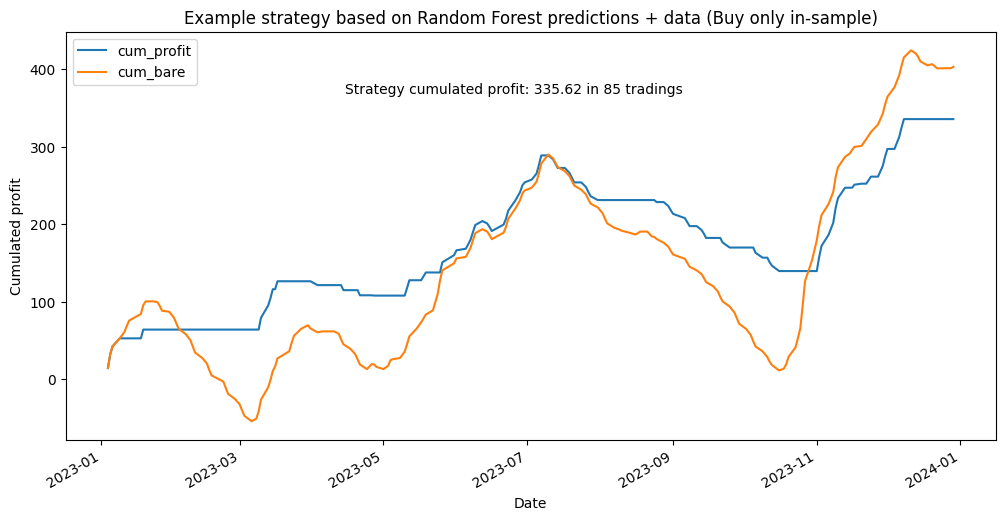

In [122]:
plot_strategy(strategy_df, "Random Forest", "+ data (Buy only in-sample)")

## Compare the two predictions

In [123]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)

In [124]:
compare_df[mask_in]

,bare_rf_pred_in,mmar_rf_pred_in
38,0,1
41,0,1
56,1,0
58,1,0
60,1,0
67,1,0
68,1,0
69,1,0
72,1,0
73,1,0


In [125]:
compare_df[mask_in].shape

(51, 2)

In [126]:
compare_df.sum(axis=0)

bare_rf_pred_in    64
mmar_rf_pred_in    85
dtype: int64